### Confirmation Bias Project
## Behavioural analyses
#### Experiment 1 | iEEG data

We recommend to run this script in Jupyter Notebook. It is possible to not visualize some plots in JupyterLab

##### Import important functions and libraries

In [14]:
# %qtconsole

In [1]:
import os, glob, platform
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
#import ptitprince as pt
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

##### Important functions

In [2]:
def RT_filter(x, sd): 
    # this function was used to filter those trials with a RT that are above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x #the same dataframe with RT filtered

def log_reg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    PSE = - reg.params.Intercept/reg.params[1]
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    return out #intercept + weight

def z_RT(x):
    # this function was used to calculate the z score of the RT values from a dataframe 
    rt_mean = x['RT'].mean()
    rt_sd   = x['RT'].std()
    x['RTz'] = (x['RT']- rt_mean)/rt_sd
    x['1/RTz']= 1/x['RT']
    rt_mean1  = x['1/RTz'].mean()
    rt_sd1    = x['1/RTz'].std()
    x['1/RTz']=(x['1/RTz']- rt_mean1)/rt_sd1
    return x

def z_DV(x):
    # this function was used to calculate the z score of the DV values from a dataframe 
    dv_mean = x['DV'].mean()
    dv_sd   = x['DV'].std()
    x['DVz'] = (x['DV']- dv_mean)/dv_sd
    return x


def cartesian(arrays, out=None):
    """
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

### Data & variables

In [3]:
# CAUTION !! 
# Change the current path to the folder where you stored the experimental results 

# Importing behavioral data from experiment 
if platform.system() == 'Darwin':
    results_path = '/Users/alex/OneDrive - Universitat de Barcelona/Projects/Condcision/Behav_data/iEEG/EXP01'
    #results_path = '/Users/alex/OneDrive - Universitat de Barcelona/PROJECTS/Condcision/Behav_data/EEG/pilot' # Mac
   # results_path = '/Users/alex/OneDrive - Universitat de Barcelona/PROJECTS/Condcision/Behav_data/iEEG/EXP01' # Mac
if platform.system() == 'Linux':
    results_path = '/home/freeman/Insync/alexisperez@ub.edu/OneDrive Biz/PROJECTS/Condcision/Behav_data/iEEG/EXP01' # Linux Mundet
    
    
    #results_path = '/home/freeman/OneDrive - Universitat de Barcelona/Projects/Condcision/Behav_data/iEEG/EXP01'  # Linux 


In [29]:

os.chdir(results_path) # change the current working directory to the results path 

all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations

nsubj = 0 # initialize subjects counter

for file in  np.sort(glob.glob("*.psydat")): 
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    pfile =  open(os.path.join(results_path, file),"rb")
    nsubj = nsubj + 1
    dat = pickle.load(pfile)
    for block in dat['main_exp']['Exp_blocks']:
        dvdata = pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])
        ddata = pd.concat([block['data'], dvdata, block['trial_orientations']], axis = 1)
        subjdata = pd.concat([subjdata, ddata], axis = 0)
    
    subjdata.insert(0, 'npar', nsubj)
    subjdata.subj = file[:4]
    
    all_df = pd.concat([all_df, subjdata], axis = 0) #concatenate each new subject

all_df.head(10)


npar  subj  nblock  ntrial  nrep  cond    DV resp  r_map  correct     RT  \
0     1  s01c       0       0     0    -1 -0.38    m     45        1  3.960   
1     1  s01c       0       0     1    -1 -0.38    m     45        1  1.088   
2     1  s01c       0       0     2    -1 -0.38    z      0        1  1.013   
3     1  s01c       0       1     0    -1 -0.28    z      0        1  1.552   
4     1  s01c       0       1     1    -1 -0.28    z      0        1  0.886   
5     1  s01c       0       1     2    -1 -0.28    z      0        1  0.873   
6     1  s01c       0       2     0    -1 -0.18    z      0        1  1.028   
7     1  s01c       0       2     1    -1 -0.18    z     45       -1  1.775   
8     1  s01c       0       2     2    -1 -0.18    z     45       -1  0.815   
9     1  s01c       0       3     0    -1 -0.08    z     45       -1  0.700   

         d1        d2        d3        d4        d5        d6     o1     o2  \
0 -0.216203 -0.162727 -0.959775 -0.379178 -0.878288  0.324169  1.263  1.242   
1 -0.216203 -0.162727 -0.959775 -0.379178 -0.878288  0.324169  1.263  1.242   
2 -0.216203 -0.162727 -0.959775 -0.379178 -0.878288  0.324169  1.263  1.242   
3 -0.061387 -0.924643  0.249284 -0.914457 -0.281374  0.232496  2.773  3.112   
4 -0.061387 -0.924643  0.249284 -0.914457 -0.281374  0.232496  2.773  3.112   
5 -0.061387 -0.924643  0.249284 -0.914457 -0.281374  0.232496  2.773  3.112   
6 -0.378140 -0.680181 -0.024699 -0.187673  0.797814 -0.668958  1.815  3.016   
7 -0.378140 -0.680181 -0.024699 -0.187673  0.797814 -0.668958  1.815  3.016   
8 -0.378140 -0.680181 -0.024699 -0.187673  0.797814 -0.668958  1.815  3.016   
9 -0.394975  0.946029 -0.244214 -0.544699 -0.071572 -0.172913  2.904  2.335   

      o3     o4     o5     o6  
0  1.555  1.327  1.523  0.520  
1  1.555  1.327  1.523  0.520  
2  1.555  1.327  1.523  0.520  
3  2.651  3.108  1.853  0.484  
4  2.651  3.108  1.853  0.484  
5  2.651  3.108  1.853  0.484  
6  0.383  0.319  0.706  0.130  
7  0.383  0.319  0.706  0.130  
8  0.383  0.319  0.706  0.130  
9  1.274  1.392  2.777  1.246

We recommend to run this script in Jupyter Notebook. It is possible to not visualize some plots in JupyterLab

##### Import important functions and libraries

##### Important functions

### Data & variables

### Dataframe experiment 1: coding important variables

In [30]:
df = all_df.copy() # copy tge variable

# relabeling some variables
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

df.insert(5, 'cond-1', 0)    # 0 = previous Diag / 1 = previous Card
df['cond-1'] = df['cond'].shift(1, fill_value  = 0)

# Inserting deci variable
df.insert(9, 'deci', 0)
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(9, 'deci-1', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'corr-1', 0) # O = incorrect / 1 = correct
df.insert(7, 'rDV', 0) # rDV (real Decision Variable)
df.insert(10, 'deci-2', 0)    # 0 = 2 previous Diag / 1 = previous Card

# Recoding variables
df['deci-1'] = df['deci'].shift(1, fill_value  = 0) # deci in trial n-1
df['deci-2'] = df['deci-1'].shift(1, fill_value  = 0) # deci in trial n-2
df['corr-1'] = df['correct'].shift(1, fill_value  = 0) # correct in trial n-1


df['rDV'] = np.mean(df.iloc[:,17:23], axis = 1) # average DV
df.head(5)

npar  subj  nblock  ntrial  nrep  cond-1  cond       rDV    DV resp  \
0     1  s01c       0       0     0       0     0 -0.378667 -0.38    m   
1     1  s01c       0       0     1       0     0 -0.378667 -0.38    m   
2     1  s01c       0       0     2       0     0 -0.378667 -0.38    z   
3     1  s01c       0       1     0       0     0 -0.283347 -0.28    z   
4     1  s01c       0       1     1       0     0 -0.283347 -0.28    z   

   deci-2  deci-1  deci  corr-1  r_map  correct     RT        d1        d2  \
0       0       0     0       0     45        1  3.960 -0.216203 -0.162727   
1       0       0     0       1     45        1  1.088 -0.216203 -0.162727   
2       0       0     0       1      0        1  1.013 -0.216203 -0.162727   
3       0       0     0       1      0        1  1.552 -0.061387 -0.924643   
4       0       0     0       1      0        1  0.886 -0.061387 -0.924643   

         d3        d4        d5        d6     o1     o2     o3     o4     o5  \
0 -0.959775 -0.379178 -0.878288  0.324169  1.263  1.242  1.555  1.327  1.523   
1 -0.959775 -0.379178 -0.878288  0.324169  1.263  1.242  1.555  1.327  1.523   
2 -0.959775 -0.379178 -0.878288  0.324169  1.263  1.242  1.555  1.327  1.523   
3  0.249284 -0.914457 -0.281374  0.232496  2.773  3.112  2.651  3.108  1.853   
4  0.249284 -0.914457 -0.281374  0.232496  2.773  3.112  2.651  3.108  1.853   

      o6  
0  0.520  
1  0.520  
2  0.520  
3  0.484  
4  0.484

### Reaction Times 
##### Filter those responses with RTs larger than 4 sd

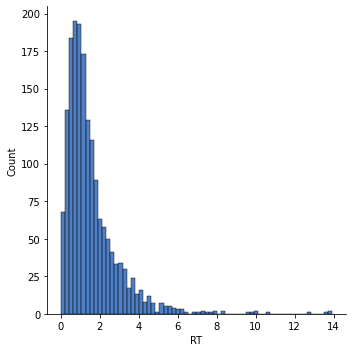

In [31]:
# RTs after apply filter
df = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 4)
sns.displot(df.RT)

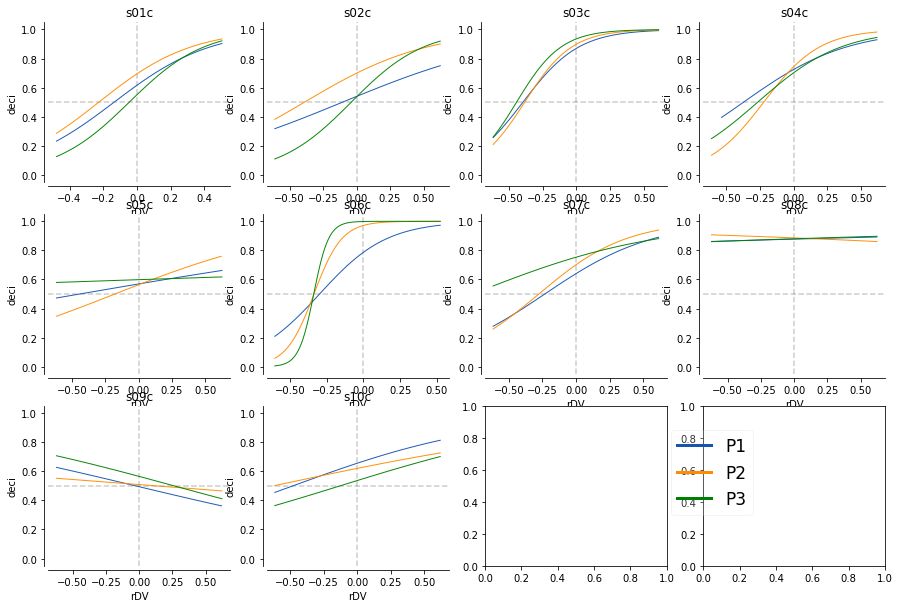

In [32]:
mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)

nprows = 3 
npcols = 4

nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar


fig, axes = plt.subplots(nprows, npcols, figsize=(15, 10))
#fig.tight_layout() # improving the space
p = cartesian((np.arange(0,nprows), np.arange(0,npcols)))

for i in npar_labels: #for loop to compute the average by each participant
    df2 = df.loc[df.npar == i,:]
    axes[p[i-1,0],p[i-1,1]].axvline(0, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].axhline(0.5, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].title.set_text(df2.iloc[0,1])
    sns.despine(ax=axes[p[i-1,0],p[i-1,1]],offset=4); # , trim=True
    for cell in nrep_labels:
            #sns.set_palette(mycol)
            sns.regplot(ax=axes[p[i-1,0],p[i-1,1]],x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                             line_kws ={'alpha':0.95, 'lw':1}); #mean all subject
    
labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
#plt.legend(lines, labels, bbox_to_anchor=(0.745,0.175), fontsize=12, framealpha= 0.2)
#plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
#axes[1].plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
#axes[1].plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)

### Removing bad participants

In [33]:
formula = "deci ~ rDV"
log_par = df.groupby(['subj']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)
log_par.head(39)
# here it seems that visual inspection shows that p13 and p15 were pretty bad

subj  level_1  intercept    weight        PSE
0  s01c        0   0.505220  3.818923  -0.132294
1  s02c        0   0.385051  2.259403  -0.170421
2  s03c        0   2.204079  5.412209  -0.407242
3  s04c        0   0.943616  3.469319  -0.271989
4  s05c        0   0.305884  0.712349  -0.429402
5  s06c        0   2.327837  7.349493  -0.316734
6  s07c        0   0.841590  2.301451  -0.365678
7  s08c        0   1.994482  0.054249 -36.765531
8  s09c        0   0.084712 -0.681027   0.124389
9  s10c        0   0.423564  1.073657  -0.394506

In [34]:
#df = df.loc[df.subj != 'p13',:] #removed because sd lower than 2 sd from mean
#df = df.loc[df.subj != 'p15',:]     #removed because not followed the instructions: counted
#df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe

### Removing bad participants

In [47]:
df = df.loc[ (df.subj != 's05c')& (df.subj != 's08c') &(df.subj != 's09c')& (df.subj != 's10c'),:] #she was very distracted and confused the keys
df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe

##### Dataset with good participants

###### The original dataset was transformed to long format to perform some of the necessary analyses
 - It allows to perform reverse correlation analyses
 - We inserted new variables to this dataset

## Plots experiment 1

Repeating the same sequence of stimuli makes the participants' estimation more similar to the real average of the sequence?

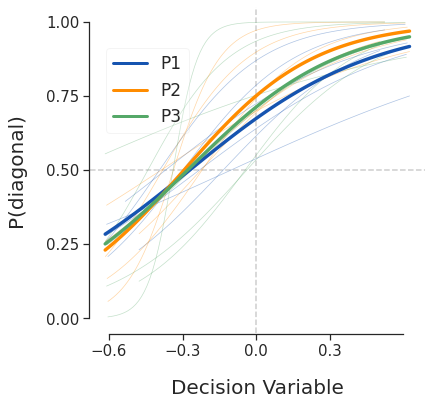

In [48]:
mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)

plt.subplots(ncols = 1, figsize = (6,6))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
for i in npar_labels: #for loop to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in nrep_labels:
        sns.set_palette(mycol)
        ax = sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                         line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject

for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=df.loc[df.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                     line_kws ={'lw':3.4});
    
sns.despine(offset=1, trim=True);
plt.ylabel('P(diagonal)', fontsize = 20, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
plt.xlabel('Decision Variable', fontdict={'size':20}, labelpad=20); 
plt.yticks(np.arange(-0., 1.1, step=0.25), fontsize = 15)
plt.xticks(np.arange(-0.6, 0.6, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
#plt.savefig('deci_x_nrep.png',bbox_inches='tight')

<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with number of presentation

In [49]:
# make the model to estimate if there are statistical differences in weight or the intercept
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['npar', 'nrep']).apply(log_reg_fit, formula) 
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.tail(5)

npar  nrep  level_2  intercept     weight       PSE
13     6     1        0   3.539424  10.477302 -0.337818
14     6     2        0   6.681273  19.692214 -0.339285
15     7     0        0   0.578052   2.484815 -0.232634
16     7     1        0   0.854382   3.088879 -0.276599
17     7     2        0   1.115890   1.451310 -0.768885

<font size="4"> _Statistical tests for Weight._

In [50]:
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)

Source         SS  DF         MS         F     p-unc  p-GG-corr       np2  \
0   nrep  31.135283   2  15.567642  1.626197  0.244641   0.258103  0.245419   
1  Error  95.730364  10   9.573036       NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.522062      False  0.084519  0.007144  
1       NaN        NaN       NaN       NaN

In [51]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within='nrep', subject='npar', padjust='bonf', 
                    effsize = 'cohen', data=log_reg_nrep) 

Contrast  A  B  Paired  Parametric         T  dof alternative     p-unc  \
0     nrep  0  1    True        True -1.935931  5.0   two-sided  0.110646   
1     nrep  0  2    True        True -1.307498  5.0   two-sided  0.247935   
2     nrep  1  2    True        True -0.882880  5.0   two-sided  0.417721   

     p-corr p-adjust   BF10     cohen  
0  0.331938     bonf  1.184 -0.777019  
1  0.743804     bonf  0.689 -0.670356  
2  1.000000     bonf  0.506 -0.280389

In [52]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'intercept', within = ['nrep'], subject = 'npar', data=log_reg_nrep, 
            detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc  p-GG-corr       np2  \
0   nrep   3.36581   2  1.682905  1.380111  0.295603    0.29359  0.216315   
1  Error  12.19398  10  1.219398       NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.517841      False  0.068907  0.004748  
1       NaN        NaN       NaN       NaN

<font size="2"> _t-test showed significant differences in weight in the third presentation compared with previous presentations._

<font size="4"> _Statistical tests for PSE._

In [53]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'PSE', within = ['nrep'], subject = 'npar', 
            data=log_reg_nrep, detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc  p-GG-corr       np2  \
0   nrep  0.012473   2  0.006236  0.235488  0.794445   0.718293  0.044979   
1  Error  0.264831  10  0.026483       NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.693405       True  0.557842  0.311188  
1       NaN        NaN       NaN       NaN

In [54]:
pg.pairwise_ttests(dv='PSE', within='nrep', subject='npar', padjust='bonf', 
                   tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

TypeError: pairwise_ttests() got an unexpected keyword argument 'tail'

<font size="2"> _t-test showed significant differences in PSE between the initial and final presentations._

# Parameters
Plotting weights and PSE

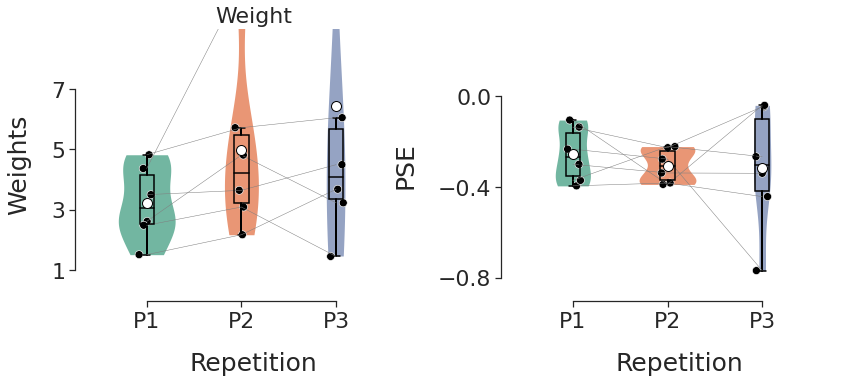

In [55]:
sns.set(style="ticks",font_scale=2)

dat = log_reg_nrep
ort = "v"; 
pal = "Set2"
dx = "nrep"; dy = "weight"; ort = "v"; pal = pal; sigma = .5
f, axes = plt.subplots(1,2,figsize=(14, 5))

# PLOTTING INTERCEPT

sns.boxplot( x = dx, y = dy, data = dat, color = "black"
      ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort, ax = axes[0])

sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
      edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
      orient = ort, ax = axes[0])

sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
     bw = 0.5, cut = 0.0,scale = "area", width = .6, 
     inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0])

sns.lineplot(x = dx, y= dy, data=dat, units= "npar" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[0])


axes[0].set_xlim([-0.75, 3])
axes[0].set_xticks([0,1,2])
axes[0].set_xticklabels(['P1','P2','P3'])
axes[0].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 


axes[0].set_ylim([0, 9])
axes[0].set_yticks(np.arange(1, 9, step=2))
axes[0].set_ylabel('Weights', fontsize = 25, labelpad=20);

axes[0].tick_params(axis='x', labelsize=22) 
axes[0].tick_params(axis='y', labelsize=22)  
axes[0].set_title('Weight',fontsize = 22)
sns.despine(offset = 1,  trim=True, ax = axes[0]);

# NOW I PLOT THE INTERCEPT
dy = "PSE"
#dy = "intercept"
sns.boxplot( x = dx, y = dy, data = dat, color = "black"
      ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort, ax = axes[1])

sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
      edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
      orient = ort, ax = axes[1])

sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
     bw = 0.5, cut = 0.0,scale = "area", width = .6, 
     inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[1])

#ax = sns.pointplot(x= dx, y= dy, data=dat, color = 'grey', errwidth = 0, size = 10, join = False, zorder = 8)
sns.lineplot(x = dx, y= dy, data=dat, units= "npar" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[1])


axes[1].set_xlim([-0.75, 3])
axes[1].set_xticks([0,1,2])
axes[1].set_xticklabels(['P1','P2','P3'])
axes[1].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 

axes[1].set_ylim([-0.9, 0.3])
axes[1].set_yticks(np.arange(-0.8, 0.3, step=0.4))
axes[1].set_ylabel('PSE', fontsize = 25, labelpad=20);

axes[1].tick_params(axis='x', labelsize=22) 
axes[1].tick_params(axis='y', labelsize=22)  
#axes[1].set_title('PSE',fontsize = 22)
sns.despine(offset = 1,  trim=True, ax = axes[1]);

<font size="5"> _Figure 3A. Logistic regression fits for each presentation separated by cardinal & diagonal._

/home/freeman/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


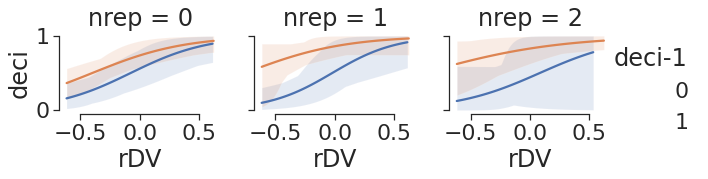

In [56]:

dat = df
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "rDV"; dy = "deci"; ort = "v"; pal = pal; sigma = .5

g = sns.lmplot(x= dx, y= dy,  col="nrep", hue = 'deci-1', units = 'subj',logistic=True, y_jitter=0, scatter_kws={'alpha':0},  ci=100,
               data=dat, height=3 )

#g = sns.lmplot(x= dx, y= dy,  col="nrep", hue = 'deci-1', logistic=True, y_jitter=0, scatter_kws={'alpha':0},  ci=True, n_boot=1,
#               data=dat, height=3)
sns.despine(offset = .5,  trim=True);


## Effect of previous decision in the current trial decision

/home/freeman/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: A

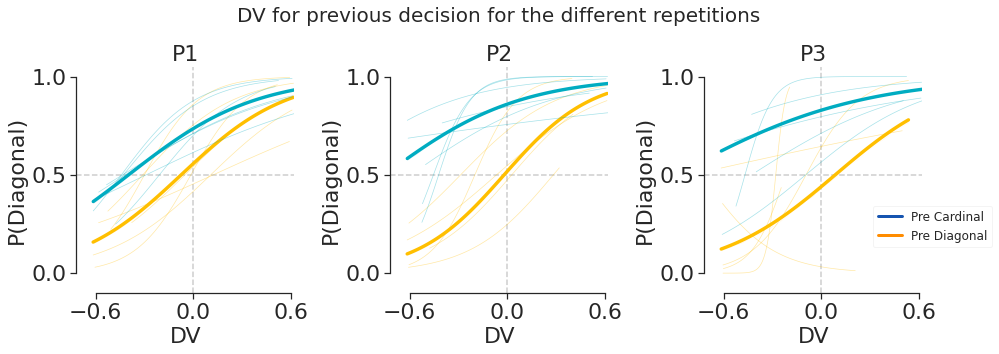

In [57]:
sns.set(font_scale = 1, style = 'ticks') 
mycol = ['#ffbf00' , '#00acc1'] #cardinal #diagonal
sns.set_palette(mycol)

titles = ['P1', 'P2', 'P3']
pre_deci_labels = np.unique(df['deci-1'])     #pre_deci
nreps = np.unique(df['nrep'])     #nreps


fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle("DV for previous decision for the different repetitions", fontsize=20)

for j in nreps:
    axes[j].axvline(0, ls='--', color= 'black', alpha = 0.2)
    axes[j].axhline(0.5, ls='--', color= 'black', alpha = 0.2)
    for cell in pre_deci_labels:
        for i in npar_labels: #this for loop makes the plot for each participant 
            dat = df.loc[(df.npar == i) & (df['deci-1'] == cell) & (df.nrep == j),:]
            sns.regplot(x="rDV", y="deci",  data= dat,
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                              label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7}, ax = axes[j], color = mycol[cell]);
        
        sns.regplot(x="rDV", y="deci",  data=df.loc[(df['deci-1'] == cell) & (df.nrep == j),:],
               logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=100,  
                          label=cell, truncate=True, line_kws={'lw':3.4}, ax = axes[j], color = mycol[cell]);
        
    # Tweaking subplots
    axes[j].set_title(titles[j],fontsize = 22)
   
    axes[j].set_xlabel('DV', fontsize = 22)
    axes[j].set_ylabel('P(Diagonal)', fontsize = 22)
    
    axes[j].set_xlim(-0.72,0.62)
    axes[j].set_xticks([-0.6,0,0.6]) 
    
    axes[j].tick_params(axis='x', labelsize=22)   
    axes[j].set_yticks([0.0,0.5,1]) 
    axes[j].set_ylim(-0.1,1.05)
    axes[j].tick_params(axis='y', labelsize=22) 
    #axes[j].xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); 
    sns.despine(ax= axes[j], offset=0.5, trim = True);
    
labels = ['Pre Cardinal', 'Pre Diagonal']; 
plt.legend(lines, labels, bbox_to_anchor=(0.745,0.175), fontsize=12, framealpha= 0.2)
        
#plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold", 
#         horizontalalignment="left")       
        #fig[j].title('P1', fontsize= 35); 
    
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.tight_layout()
#axes[0].ylabel('p(diagonal)', fontsize = 20, labelpad=20); axes[0].yticks(np.arange(0, 1.1, step=0.25), fontsize = 25); plt.xlabel(' ', fontsize = 0)


<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with previous decision by each presentation

In [58]:
formula = "deci ~ rDV"
log_reg_preDeci = df.groupby(['npar', 'nrep', 'deci-1']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head(6)

PerfectSeparationError: Perfect separation detected, results not available

In [ ]:
dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 0,:] # with pre_deci as a factor
print(np.mean(dat.weight))
print()

dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 1,:] # with pre_deci as a factor
print(np.mean(dat.weight))
print()

dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 2,:] # with pre_deci as a factor
print(np.mean(dat.weight))

In [ ]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_deci'], subject = 'npar', 
            data=log_reg_preDeci, detailed = True, correction = True)

In [ ]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
pg.pairwise_ttests(dv='weight', within= ['nrep', 'pre_deci'], subject='npar', padjust='bonf',
                   tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

<font size="2"> _t-test showed significantly that previous choices reduced discriminability from P1 to P2 and from P1 to P3._

<font size="4"> Statistical tests for PSE

In [ ]:
df.reset_index(drop=True, inplace=True) # function resets the row indexes of the pandas dataframe
pg.rm_anova(dv = 'PSE', within = ['nrep', 'pre_deci'], subject = 'npar', 
            data=log_reg_preDeci, detailed = True, correction = True)

Source         SS  ddof1  ddof2         MS          F     p-unc  \
0             nrep   1.423181      2     52   0.711590   0.802917  0.453496   
1         pre_deci  35.723772      1     26  35.723772  21.888779  0.000079   
2  nrep * pre_deci  19.139836      2     52   9.569918   9.349854  0.000340   

   p-GG-corr       np2       eps  
0   0.453466  0.029956  0.999717  
1   0.000079  0.457075  1.000000  
2   0.000372  0.264495  0.982958

In [ ]:
pg.pairwise_ttests(dv='PSE', within= ['pre_deci', 'nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

Contrast pre_deci  A  B Paired  Parametric         T   dof  \
0         pre_deci        -  0  1   True        True  4.678544  26.0   
1             nrep        -  0  1   True        True -0.282102  26.0   
2             nrep        -  0  2   True        True  0.931011  26.0   
3             nrep        -  1  2   True        True  1.201172  26.0   
4  pre_deci * nrep        0  0  1   True        True -4.937436  26.0   
5  pre_deci * nrep        0  0  2   True        True -4.193148  26.0   
6  pre_deci * nrep        0  1  2   True        True  0.152242  26.0   
7  pre_deci * nrep        1  0  1   True        True  1.640282  26.0   
8  pre_deci * nrep        1  0  2   True        True  2.819131  26.0   
9  pre_deci * nrep        1  1  2   True        True  1.126972  26.0   

        Tail     p-unc    p-corr p-adjust     BF10     cohen  
0  two-sided  0.000079       NaN      NaN  329.486  1.235830  
1  two-sided  0.780099  1.000000     bonf    0.211 -0.075189  
2  two-sided  0.360413  1.000000     bonf    0.302  0.246956  
3  two-sided  0.240513  0.721539     bonf     0.39  0.233577  
4  two-sided  0.000040  0.000238     bonf  611.452 -1.547917  
5  two-sided  0.000282  0.001692     bonf  104.576 -1.327330  
6  two-sided  0.880172  1.000000     bonf    0.206  0.020806  
7  two-sided  0.112991  0.677947     bonf    0.665  0.440853  
8  two-sided  0.009087  0.054524     bonf    5.055  0.747797  
9  two-sided  0.270048  1.000000     bonf    0.361  0.236383

In [ ]:
dat =log_reg_preDeci.loc[log_reg_preDeci.nrep == 0]
pg.pairwise_ttests(dv='PSE', within= ['pre_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0  pre_deci  0  1    True        True -0.071054  26.0  two-sided  0.943898   

    BF10     cohen  
0  0.204 -0.013457

In [ ]:
dat = log_reg_preDeci.loc[log_reg_preDeci['deci-1'] == 1]
pg.ttest(dat['PSE'], 0)

T  dof       tail     p-val           CI95%   cohen-d    BF10  \
T-test -4.242337   80  two-sided  0.000059  [-1.05, -0.38]  0.471371  322.25   

           power  
T-test  0.987157

In [22]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci.loc[log_reg_preDeci['deci-1'] == 0] #cardinal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

NameError: name 'log_reg_preDeci' is not defined

In [19]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci.loc[log_reg_preDeci['deci-1'] == 1] #diagonal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

NameError: name 'log_reg_preDeci' is not defined

<font size="2"> post-hoc t-test showed:
    
    
<font size="2"> 1. _PSE in Cardinal condition: PSE displacement in P2 and P3 was significant compared with the PSE in P1._ 
    
<font size="2"> 2. _PSE in Diagonal condition: PSE displacement in P3 was significant compared with the PSE in P1._

<font size="5"> _Figure 3B. Beta weight by presentation and condition._

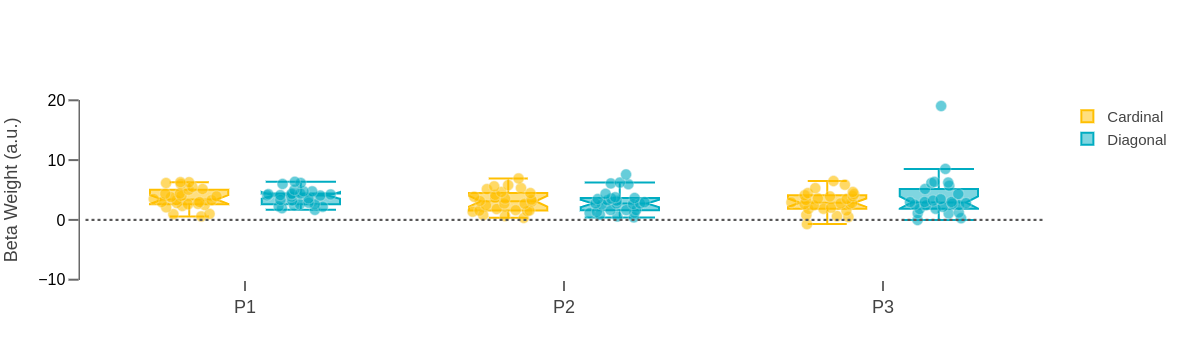

In [ ]:
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci['deci-1'] == 0),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=  "#ffbf00"))

dat = log_reg_preDeci.loc[(log_reg_preDeci['deci-1'] == 1),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Diagonal', marker_color= '#00acc1'))

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta Weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   ))


fig['layout']['yaxis'].update(range=[-10.05, 20.05]);

fig.show()

<font size="5"> _Figure 3C. PSE by presentation and condition._

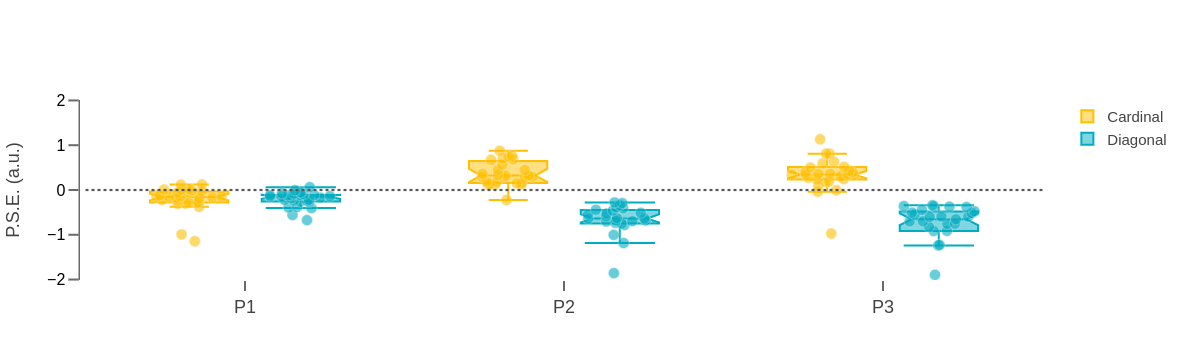

In [ ]:
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci['deci-1'] == 0),:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color="#ffbf00"))

dat = log_reg_preDeci.loc[(log_reg_preDeci['deci-1'] == 1),:]
fig.add_trace(go.Box(y=dat['PSE'],x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Diagonal',marker_color='#00acc1'))

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="P.S.E. (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig['layout']['yaxis'].update(range=[-2.01, 2.01]);

fig.show()

<font size="5"> _Figure 4A. Beta Weight by presentation and sample._

NameError: name 'log_regstim_params' is not defined

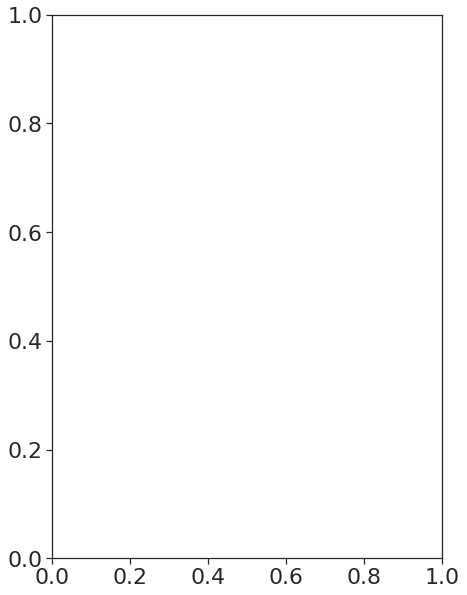

In [18]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.npar)

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="weight", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Weight', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="weight", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

ind = ind = np.arange(6)
plt.ylabel('Beta weight (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.3,0.2), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_weight4part.png',bbox_inches='tight')

<font size="4"> Statistical tests for Weight

In [ ]:
# ANOVA to check if weight depends on the position of the stimuli sample: recency and primacy bias

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', 
            data=log_regstim_params, detailed = True, correction = True)

/home/freeman/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:459: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS          F     p-unc  \
0         nrep  1.052703      2     50  0.526352  10.891371  0.000119   
1         stim  1.224314      5    125  0.244863   1.893686  0.100038   
2  nrep * stim  0.259867     10    250  0.025987   1.419852  0.171671   

   p-GG-corr       np2       eps  
0   0.000281  0.303454  0.864022  
1   0.113745  0.070414  0.839404  
2   0.232021  0.053742  0.407799

In [20]:
formula = "deci ~ dv"
log_regstim_params = dflong.groupby(['npar','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)


In [ ]:
log_regstim_params

npar  nrep stim  level_3  intercept    weight       PSE
0       1     0   d1        0  -0.913563 -1.029562 -0.887331
1       1     0   d2        0  -0.883891 -0.910509 -0.970765
2       1     0   d3        0  -0.871265 -0.733091 -1.188482
3       1     0   d4        0  -0.863337 -0.799175 -1.080286
4       1     0   d5        0  -0.816901 -0.648715 -1.259261
..    ...   ...  ...      ...        ...       ...       ...
463    29     2   d2        0  -0.342614 -0.320535 -1.068882
464    29     2   d3        0  -0.358326 -0.424277 -0.844557
465    29     2   d4        0  -0.374224 -0.598483 -0.625288
466    29     2   d5        0  -0.334473 -0.521094 -0.641866
467    29     2   d6        0  -0.327662 -0.570122 -0.574723

[468 rows x 7 columns]

In [21]:
# post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'stim'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=False, data=log_regstim_params) 

Contrast   A   B  Paired  Parametric         T  dof alternative     p-unc  \
0      nrep   0   1    True        True -2.205094  8.0   two-sided  0.058527   
1      nrep   0   2    True        True -0.850800  8.0   two-sided  0.419616   
2      nrep   1   2    True        True  0.623489  8.0   two-sided  0.550322   
3      stim  d1  d2    True        True -1.924082  8.0   two-sided  0.090544   
4      stim  d1  d3    True        True -1.874530  8.0   two-sided  0.097724   
5      stim  d1  d4    True        True -1.472596  8.0   two-sided  0.179078   
6      stim  d1  d5    True        True -0.571444  8.0   two-sided  0.583392   
7      stim  d1  d6    True        True -1.256240  8.0   two-sided  0.244471   
8      stim  d2  d3    True        True  0.487501  8.0   two-sided  0.638981   
9      stim  d2  d4    True        True  0.143365  8.0   two-sided  0.889547   
10     stim  d2  d5    True        True  0.648102  8.0   two-sided  0.535073   
11     stim  d2  d6    True        True  1.334814  8.0   two-sided  0.218675   
12     stim  d3  d4    True        True -0.284768  8.0   two-sided  0.783054   
13     stim  d3  d5    True        True  0.556311  8.0   two-sided  0.593213   
14     stim  d3  d6    True        True  0.628718  8.0   two-sided  0.547061   
15     stim  d4  d5    True        True  0.517373  8.0   two-sided  0.618893   
16     stim  d4  d6    True        True  0.805083  8.0   two-sided  0.444039   
17     stim  d5  d6    True        True -0.079378  8.0   two-sided  0.938682   

      p-corr p-adjust   BF10     cohen  
0   0.175581     bonf  1.623 -0.299770  
1   1.000000     bonf  0.433 -0.146946  
2   1.000000     bonf  0.378  0.121590  
3   1.000000     bonf  1.177 -0.404032  
4   1.000000     bonf  1.114 -0.306453  
5   1.000000     bonf   0.73 -0.320014  
6   1.000000     bonf  0.369 -0.170139  
7   1.000000     bonf  0.596 -0.205958  
8   1.000000     bonf  0.356  0.112689  
9   1.000000     bonf  0.324  0.028422  
10  1.000000     bonf  0.383  0.224090  
11  1.000000     bonf   0.64  0.219101  
12  1.000000     bonf  0.333 -0.068812  
13  1.000000     bonf  0.366  0.121310  
14  1.000000     bonf  0.379  0.109204  
15  1.000000     bonf   0.36  0.168203  
16  1.000000     bonf   0.42  0.159411  
17  1.000000     bonf  0.322 -0.020481

<font size="2"> _t-test showed that discriminabilty was larger in the third sample than in the first one._

<font size="5"> _Figure 4B. Intercept by presentation and sample._

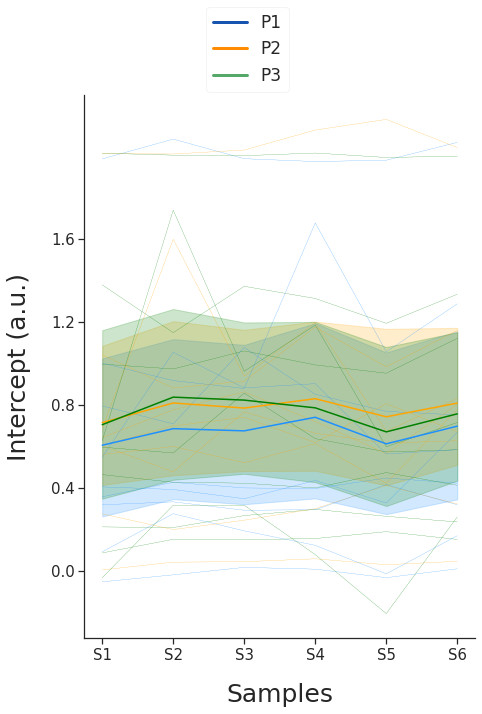

In [22]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.npar)#npar

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="intercept", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Intercept', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="intercept", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('Intercept (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) 
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.29,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_intercept4part.png',bbox_inches='tight')

<font size="4"> Statistical tests for Inercept

In [ ]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', 
            data=log_regstim_params, detailed = True, correction = True)

/home/freeman/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:459: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS         F     p-unc  \
0         nrep  0.060078      2     50  0.030039  0.499465  0.609851   
1         stim  0.012628      5    125  0.002526  0.608137  0.693803   
2  nrep * stim  0.001859     10    250  0.000186  0.796340  0.632372   

   p-GG-corr       np2       eps  
0   0.606512  0.019587  0.981766  
1   0.668350  0.023748  0.854648  
2   0.430930  0.030870  0.157632

<font size="2"> _There were non statisitcal differences in sample position and intercept._

<font size="5"> _Figure 5 A & B. Category similarity between consecutive samples._

Logisitc regression model with the category of the previous stimuli sample

In [23]:
# First, build a logistic model with presentations and the category of previous sample

formula = "deci ~ dv"

log_regpre_deci_params = dflong_seq.groupby(['npar', 'nrep', 'cong_stim_DV']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

npar  nrep  cong_stim_DV  level_3  intercept    weight       PSE
0     1     0             0        0   0.026841 -0.667295  0.040223
1     1     0             1        0  -0.207549 -0.601178 -0.345237
2     1     1             0        0  -0.045839 -0.171611 -0.267109
3     1     1             1        0   0.611391 -0.350790  1.742897
4     1     2             0        0   0.324331 -0.918163  0.353239

<font size="5"> _5A. Beta Weight._

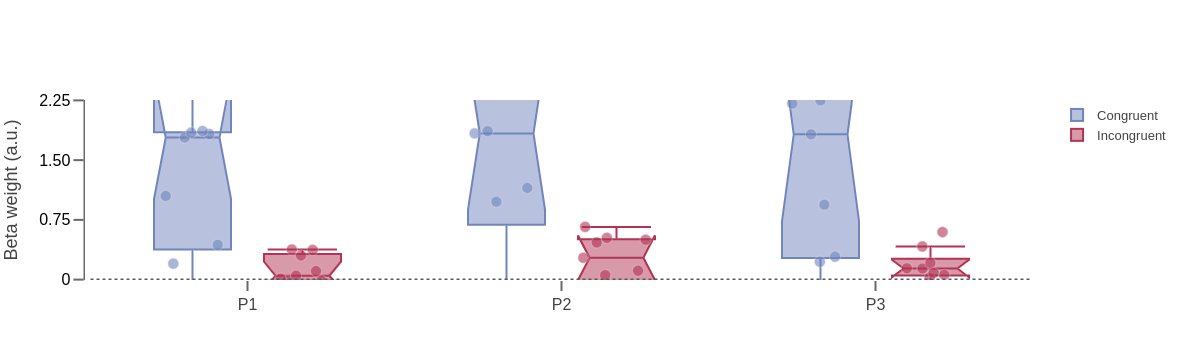

In [24]:
fig = go.Figure()
data = log_regpre_deci_params

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.cong_stim_DV == 0),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', jitter=0.99, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd'))

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.cong_stim_DV == 1),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .75, 1.50, 2.25], ticktext=['0', '0.75', '1.50', '2.25', '1', '1.25'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",size=15, color= "#424242" ))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.255])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [25]:
#Checking statistical differences in Weight between the number of repetitions & the previous sample category
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

pg.rm_anova(dv = 'weight', within = ['cong_stim_DV','nrep'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

#Weight was larger in those samples that followed a sample from the same category

Source         SS  ddof1  ddof2         MS          F  \
0         cong_stim_DV  18.855852      1      8  18.855852  13.624786   
1                 nrep   0.403129      2     16   0.201564   1.633987   
2  cong_stim_DV * nrep   0.026692      2     16   0.013346   0.122598   

      p-unc  p-GG-corr       np2       eps  
0  0.006120   0.006120  0.630054  1.000000  
1  0.226085   0.228944  0.169607  0.914018  
2  0.885443   0.804692  0.015093  0.672009

Post-hoc t-test

In [26]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV','nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen',interaction=False, data=log_regpre_deci_params) 

Contrast  A  B  Paired  Parametric         T  dof alternative  \
0  cong_stim_DV  0  1    True        True  3.691177  8.0   two-sided   
1          nrep  0  1    True        True -1.991669  8.0   two-sided   
2          nrep  0  2    True        True -1.267912  8.0   two-sided   
3          nrep  1  2    True        True  0.486941  8.0   two-sided   

      p-unc    p-corr p-adjust   BF10     cohen  
0  0.006120       NaN      NaN  9.409  1.484523  
1  0.081562  0.244686     bonf   1.27 -0.312078  
2  0.240484  0.721452     bonf  0.602 -0.221235  
3  0.639361  1.000000     bonf  0.356  0.093610

In [ ]:
# post-hoc t-test for P1
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 0] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast  A  B  Paired  Parametric          T   dof alternative  \
0  cong_stim_DV  0  1    True        True  21.841237  25.0   two-sided   

          p-unc       BF10     cohen  
0  8.392776e-18  5.298e+14  6.190066

In [ ]:
# post-hoc t-test for P2
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 1] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast  A  B  Paired  Parametric          T   dof alternative  \
0  cong_stim_DV  0  1    True        True  17.135181  25.0   two-sided   

          p-unc       BF10     cohen  
0  2.502906e-15  2.298e+12  4.568467

In [ ]:
# post-hoc t-test for P3
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 2] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast  A  B  Paired  Parametric          T   dof alternative  \
0  cong_stim_DV  0  1    True        True  18.942506  25.0   two-sided   

          p-unc      BF10     cohen  
0  2.425581e-16  2.13e+13  4.898787

<font size="5"> _5B. Intercept._

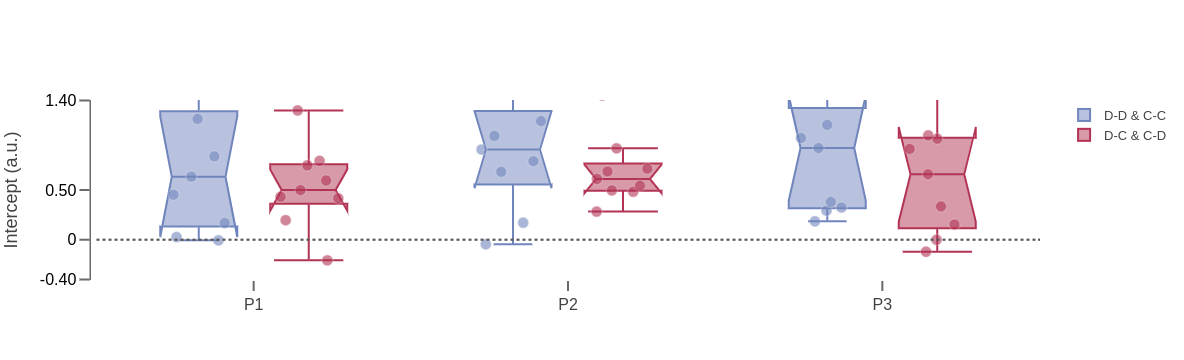

In [27]:
fig = go.Figure()
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.cong_stim_DV == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],x=dat['nrep'],boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='D-D & C-C', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd')) 

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.cong_stim_DV == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='D-C & C-D', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15,color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, 
              line=dict(color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Inercept

In [ ]:
#Checking statistical differences in Intercept between the number of repetitions 
# & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_stim'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

# no differences in the intercept

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0             nrep  0.020666      2     52  0.010333  0.516653  0.599543   
1         pre_stim  0.349316      1     26  0.349316  8.969096  0.005960   
2  nrep * pre_stim  0.005757      2     52  0.002878  0.762662  0.471569   

   p-GG-corr       np2       eps  
0   0.598899  0.019484  0.996376  
1   0.005960  0.256486  1.000000  
2   0.460285  0.028497  0.907134

In [ ]:
pg.pairwise_ttests(dv='intercept', within=['pre_stim', 'nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=log_regpre_deci_params) 

Contrast pre_stim  A  B Paired  Parametric         T   dof  \
0         pre_stim        -  0  1   True        True  2.994845  26.0   
1             nrep        -  0  1   True        True  0.977335  26.0   
2             nrep        -  0  2   True        True  0.649050  26.0   
3             nrep        -  1  2   True        True -0.373029  26.0   
4  pre_stim * nrep        0  0  1   True        True  1.271739  26.0   
5  pre_stim * nrep        0  0  2   True        True  0.815741  26.0   
6  pre_stim * nrep        0  1  2   True        True -0.532817  26.0   
7  pre_stim * nrep        1  0  1   True        True  0.447472  26.0   
8  pre_stim * nrep        1  0  2   True        True  0.344832  26.0   
9  pre_stim * nrep        1  1  2   True        True -0.118930  26.0   

        Tail     p-unc  p-corr p-adjust   BF10     cohen  
0  two-sided  0.005960     NaN      NaN  7.235  0.278307  
1  two-sided  0.337410     1.0     bonf  0.314  0.085460  
2  two-sided  0.521999     1.0     bonf  0.247  0.048439  
3  two-sided  0.712151     1.0     bonf  0.217 -0.031116  
4  two-sided  0.214724     1.0     bonf   0.42  0.126499  
5  two-sided  0.422059     1.0     bonf  0.276  0.064534  
6  two-sided  0.598686     1.0     bonf  0.232 -0.050571  
7  two-sided  0.658240     1.0     bonf  0.223  0.038672  
8  two-sided  0.732995     1.0     bonf  0.215  0.027723  
9  two-sided  0.906245     1.0     bonf  0.205 -0.008887

In [ ]:
# post-hoc t-test for P1

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==0]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  3.001301  26.0  two-sided   

      p-unc   BF10     cohen  
0  0.005867  7.332  0.294823

In [ ]:
# post-hoc t-test for P2

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==1]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  2.830166  26.0  two-sided   

      p-unc   BF10     cohen  
0  0.008852  5.168  0.267804

In [ ]:
# post-hoc t-test for P3

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==2]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  2.483398  26.0  two-sided   

      p-unc   BF10     cohen  
0  0.019786  2.638  0.248507

<font size="5"> _Figure 5 C & D. Physical similarity between consecutive samples._

<font size="5"> _5C. Beta Weight._

Logisitc regression model with the physical similarity with previous sample

In [59]:
formula = "deci ~ dv"

log_regpre_orient_params = dflong_seq.groupby(['npar', 'nrep', 'cong_stim_OV']).apply(log_reg_fit, formula)
log_regpre_orient_params.reset_index(inplace = True)
log_regpre_orient_params.head()

npar  nrep  cong_stim_OV  level_3  intercept    weight       PSE
0     1     0             0        0   0.117029  0.836927 -0.139832
1     1     0             1        0   0.204011  0.589377 -0.346146
2     1     1             0        0   0.463253  1.026543 -0.451275
3     1     1             1        0   1.104505  0.908107 -1.216272
4     1     2             0        0  -0.036010  1.403527  0.025657

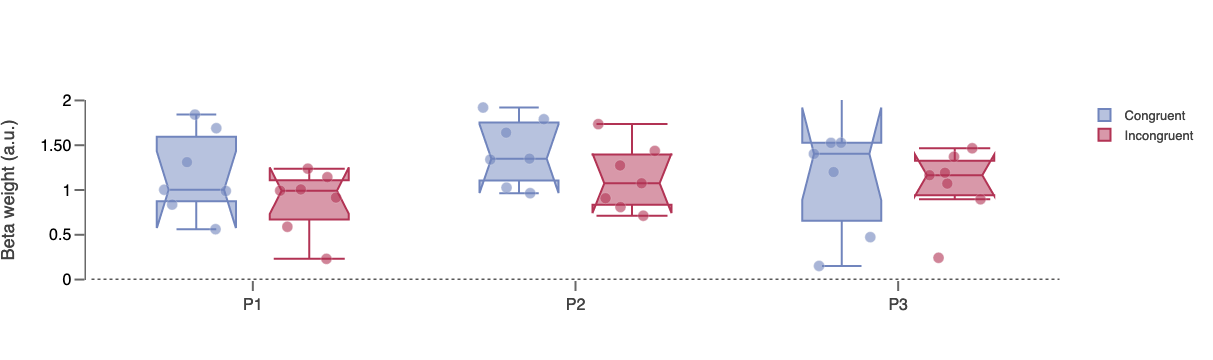

In [60]:
# Stimulus following one similar orientated (do not differ in many degrees) are weighted less than others
# preceded by stimuli from distant orientations.

fig = go.Figure()
data = log_regpre_orient_params

dat = log_regpre_orient_params.loc[(log_regpre_orient_params['cong_stim_OV'] == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another similar oriented
    y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another similar in orientation
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params['cong_stim_OV'] == 1),:]
fig.add_trace(go.Box( #condition for samples that follow stimuli pysichaly similar
    y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .5, 1, 1.50, 2], ticktext=['0', '0.5', '1', '1.50', '2'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.005])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [ ]:
# Checking statistical differences in 
# Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_stim_OV'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS          F     p-unc  \
0                 nrep  0.257873      2     50  0.128937   7.643737  0.001269   
1         cong_stim_OV  1.206203      1     25  1.206203  11.904366  0.002000   
2  nrep * cong_stim_OV  0.018020      2     50  0.009010   1.057409  0.354993   

   p-GG-corr       np2       eps  
0   0.001736  0.234156  0.925437  
1   0.002000  0.322573  1.000000  
2   0.351333  0.040580  0.929771

In [ ]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=log_regpre_orient_params) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0        nrep  0.0  1.0    True        True -1.125617  26.0  two-sided   
1        nrep  0.0  2.0    True        True -4.335024  26.0  two-sided   
2        nrep  1.0  2.0    True        True -3.548843  26.0  two-sided   
3  pre_orient  0.0  1.0    True        True -6.280211  26.0  two-sided   

      p-unc    p-corr p-adjust       BF10     cohen  
0  0.270611  0.811834     bonf      0.361 -0.160350  
1  0.000194  0.000583     bonf    145.935 -0.542633  
2  0.001498  0.004494     bonf     23.891 -0.316516  
3  0.000001       NaN      NaN  1.503e+04 -1.044517

Post-hoc t-test to look for interactions within categories

In [ ]:
# post-hoc t-test for P1

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 0]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -5.305021  26.0  two-sided   

      p-unc      BF10     cohen  
0  0.000015  1474.949 -1.105405

In [ ]:
# post-hoc t-test for P2

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 1]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -5.316472  26.0  two-sided   

      p-unc      BF10     cohen  
0  0.000015  1515.975 -0.893998

In [ ]:
# post-hoc t-test for P3

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 2]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -5.988884  26.0  two-sided   

      p-unc      BF10     cohen  
0  0.000003  7548.418 -0.959297

<font size="5"> _5D. Intercept._

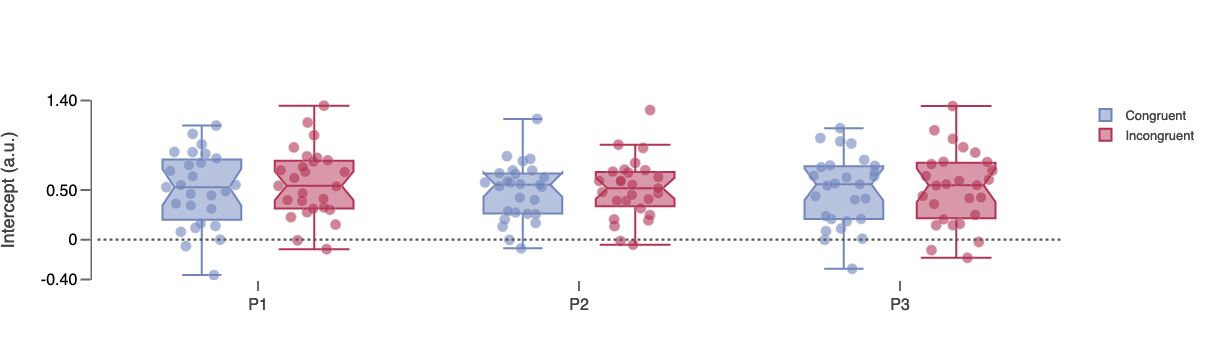

In [ ]:
fig = go.Figure()

data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another pyshically similar
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4) ),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Intercept

In [ ]:
#statistical test in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_orient'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0               nrep  0.039290      2     52  0.019645  1.015189  0.369402   
1         pre_orient  0.055587      1     26  0.055587  2.131919  0.156239   
2  nrep * pre_orient  0.018495      2     52  0.009247  2.246483  0.115940   

   p-GG-corr       np2       eps  
0   0.369034  0.037578  0.993656  
1   0.156239  0.075783  1.000000  
2   0.123065  0.079531  0.881712

<font size="5"> _Supplementary Figure 1A. Beta Weight for physical similarity between stimuli samples and previous decisions._

Logisitc regression model with congruency with stimuli sample by each presentation

In [ ]:
dflong_seq.head(4)

npar subj  nblock  ntrial  nrep stim_cond  cond-1 cong_deci cong_stim  \
1     1  p03       0       0     0         D       0         I         I   
2     1  p03       0       0     0         C       0         C         C   
3     1  p03       0       0     0         C       0         C         C   
4     1  p03       0       0     0         D       0         I         I   

   cond  deci-2  deci-1  deci  corr-1  correct     RT stim        dv  \
1     1       0       0     1       0        1  0.735   d2  0.233015   
2     1       0       0     1       0        1  0.735   d3 -0.101612   
3     1       0       0     1       0        1  0.735   d4 -0.280384   
4     1       0       0     1       0        1  0.735   d5  0.738727   

       orient        ov  abs_diffDV  cong_stim_DV  stim_cat_OV  abs_diffOV  \
1  117.742827  0.383493    0.324912             0            1           1   
2   69.786259  0.550806    0.334626             1            1           1   
3  163.808634 -0.640192    0.178772             0            0           0   
4   50.878652  0.130637    1.019110             1            1           1   

   cong_stim_OV  
1             0  
2             0  
3             1  
4             1

In [68]:
ds = dflong.loc[dflong.nrep != 0]

In [28]:
formula = "deci ~ dv"
log_reg_cong_stim = dflong.groupby(['npar', 'cong_deci', 'nrep', 'stim_cond']).apply(log_reg_fit, formula) 
log_reg_cong_stim.reset_index(inplace = True)
log_reg_cong_stim.head(5)

PerfectSeparationError: Perfect separation detected, results not available

'\n# you can access different features of the plot nad panels using for loops\nfor (row_val, col_val), ax in g.axes_dict.items():\n    if row_val == "Lunch" and col_val == "Female":\n        ax.set_facecolor(".95")\n    else:\n        ax.set_facecolor((0, 0, 0, 0))\n#g.savefig("facet_plot.png")\n'

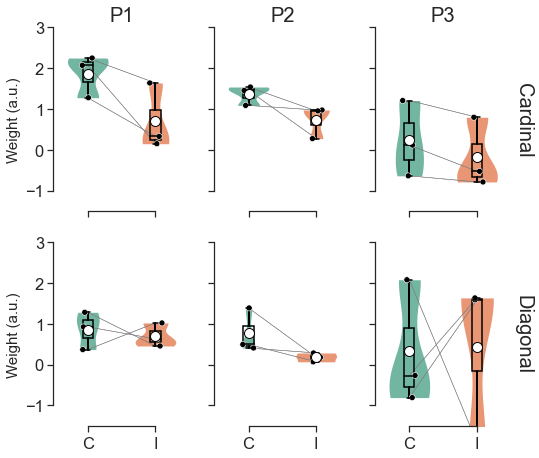

In [32]:
sns.set(font_scale = 1.5, style = 'ticks') 
dat = log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_deci"; dy = "weight"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , row= 'stim_cond', col = 'nrep', height= 3.5, aspect=.75,margin_titles=True)
g.set(ylim=[-1.5,3], yticks=[-1, 0, 1, 2, 3])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy, data=dat, units= "npar" , estimator=None, color = 'grey',linewidth = 0.5, zorder = 1)
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "npar" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
g._margin_titles_texts[0].set_text("Cardinal")
g._margin_titles_texts[0].set_size("20")
g._margin_titles_texts[1].set_text("Diagonal")
g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Weight (a.u.)", fontsize = 15 )
#g.tight_layout()


'''
# you can access different features of the plot nad panels using for loops
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == "Lunch" and col_val == "Female":
        ax.set_facecolor(".95")
    else:
        ax.set_facecolor((0, 0, 0, 0))
#g.savefig("facet_plot.png")
'''

In [ ]:
g.margin_title[0]


AttributeError: 'FacetGrid' object has no attribute 'margin_title'

In [ ]:
for margin_title in grid._margin_titles_texts:
    margin_title.set_color("red")

In [ ]:
looking_outliers = log_reg_cong_stim.loc[log_reg_cong_stim.nrep == 2]
looking_outliers.tail(6)

npar cong_deci  nrep  cond  level_4  intercept    weight       PSE
298    28         I     2     0        0   0.020161 -1.803439  0.011179
299    28         I     2     1        0   1.689875 -2.225479  0.759331
304    29         C     2     0        0   0.004868  2.145449 -0.002269
305    29         C     2     1        0   0.956274  1.014332 -0.942763
310    29         I     2     0        0   0.197833 -2.262122  0.087455
311    29         I     2     1        0   0.379394 -1.449773  0.261692

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
#fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))
#fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))
#fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], boxpoints='all',
    jitter=.99, pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['weight'], x=dat['cong_deci'], opacity = 1, showlegend=False, boxpoints='all',
    jitter=.99, pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(  y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( 
    y=dat['weight'], x=dat['cong_deci'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_yaxes(showgrid=False)

fig.update_layout(yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

#fig['layout']['yaxis1'].update(range=[-1.005, 2.51]); fig['layout']['yaxis2'].update(range=[-1.005, 2.51])
#fig['layout']['yaxis3'].update(range=[-1.005, 2.51])

fig.show()

AttributeError: 'DataFrame' object has no attribute 'cond'

<font size="4"> Statistical tests for Beta Weight

In [ ]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.stim_cond == 'C') & (log_reg_cong_stim.nrep != 0)]
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0              nrep  0.206328      1     25  0.206328  0.490596  0.490129   
1         cong_deci  4.849159      1     25  4.849159  8.737506  0.006711   
2  nrep * cong_deci  0.000476      1     25  0.000476  0.001535  0.969058   

   p-GG-corr       np2  eps  
0   0.490129  0.019246  1.0  
1   0.006711  0.258985  1.0  
2   0.969058  0.000061  1.0

In [ ]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast nrep  A  B Paired  Parametric          T   dof       Tail  \
0              nrep    -  0  1   True        True  11.070187  26.0  two-sided   
1              nrep    -  0  2   True        True   8.199577  26.0  two-sided   
2              nrep    -  1  2   True        True  -0.839986  26.0  two-sided   
3         cong_stim    -  C  I   True        True  -0.430513  26.0  two-sided   
4  nrep * cong_stim    0  C  I   True        True  -1.305173  26.0  two-sided   
5  nrep * cong_stim    1  C  I   True        True   0.286044  26.0  two-sided   
6  nrep * cong_stim    2  C  I   True        True  -0.097211  26.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  2.450018e-11  7.350053e-11     bonf  3.736e+08  2.233195  
1  1.110960e-08  3.332881e-08     bonf  1.173e+06  1.874948  
2  4.085745e-01  1.000000e+00     bonf      0.281 -0.120581  
3  6.703707e-01           NaN      NaN      0.222 -0.115840  
4  2.032672e-01  6.098015e-01     bonf      0.437 -0.382671  
5  7.771112e-01  1.000000e+00     bonf      0.212  0.081996  
6  9.233044e-01  1.000000e+00     bonf      0.205 -0.025444

In [ ]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cong_stim == 'C'),:]
pg.rm_anova(dv = 'weight', within = ['cond'], subject = 'npar', data=dat, detailed = True, correction = True)

Source        SS  DF        MS          F     p-unc       np2  eps
0   cond  3.517647   1  3.517647  19.769313  0.000145  0.431934  1.0
1  Error  4.626302  26  0.177935        NaN       NaN       NaN  NaN

<font size="5"> _Supplementary Figure 1B. Intercept for Physical similarity between stimuli samples and previous decisions._

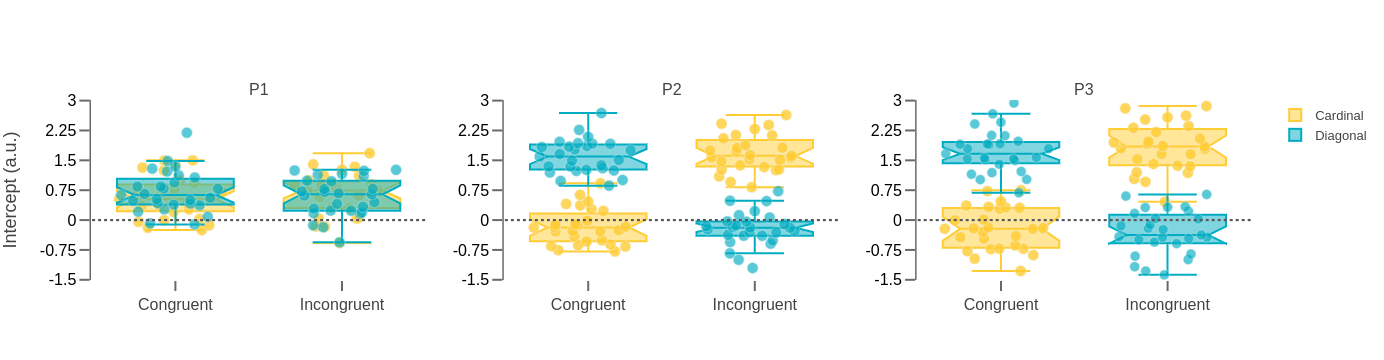

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal',
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=10,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.5,-0.75, 0, 0.75, 1.5, 2.25, 3], 
                 ticktext=['-1.5','-0.75', '0', '0.75', '1.5' ,'2.25', '3'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.505, 3.015]); fig['layout']['yaxis2'].update(range=[-1.505, 3.015])
fig['layout']['yaxis3'].update(range=[-1.505, 3.015],)

fig.show()

<font size="4"> Statistical tests for Intercept

In [ ]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_stim'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source         SS  ddof1  ddof2         MS           F  \
0              nrep   0.106604      2     52   0.053302    1.405071   
1         cong_stim  71.439302      1     26  71.439302  342.787419   
2  nrep * cong_stim  29.185073      2     52  14.592537  194.679087   

          p-unc     p-GG-corr       np2       eps  
0  2.545089e-01  2.548169e-01  0.051270  0.932192  
1  1.704312e-16  1.704312e-16  0.929499  1.000000  
2  7.104220e-25  8.008772e-21  0.882182  0.820243

In [ ]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast nrep  A  B Paired  Parametric          T   dof       Tail  \
0              nrep    -  0  1   True        True  -1.423697  26.0  two-sided   
1              nrep    -  0  2   True        True  -1.466176  26.0  two-sided   
2              nrep    -  1  2   True        True  -0.365952  26.0  two-sided   
3         cong_stim    -  C  I   True        True  18.514519  26.0  two-sided   
4  nrep * cong_stim    0  C  I   True        True   1.250214  26.0  two-sided   
5  nrep * cong_stim    1  C  I   True        True  21.684017  26.0  two-sided   
6  nrep * cong_stim    2  C  I   True        True  22.650209  26.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  1.664252e-01  4.992756e-01     bonf      0.502 -0.117921  
1  1.545916e-01  4.637747e-01     bonf      0.529 -0.133234  
2  7.173619e-01  1.000000e+00     bonf      0.217 -0.032899  
3  1.704312e-16           NaN      NaN  3.044e+13  2.954235  
4  2.223572e-01  6.670715e-01     bonf      0.411  0.268860  
5  3.566698e-18  1.070009e-17     bonf   1.23e+15  4.279840  
6  1.213097e-18  3.639292e-18     bonf  3.456e+15  3.767159

<font size="5"> _Figure 6A. Beta Weight for Categorical similarity between stimuli samples and previous decisions._

<font size="3"> _Logisitc regression model to plot Figure 6_

In [ ]:
formula = "deci ~ dv"
log_reg_cong_deci = dflong.groupby(['npar', 'cong_deci', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_deci.reset_index(inplace = True)
log_reg_cong_deci.head()

npar cong_deci  nrep cond  level_4  intercept    weight       PSE
0   1.0         C     0    C        0   0.195054  0.571804 -0.341120
1   1.0         C     0    D        0   0.530885  1.448131 -0.366600
2   1.0         C     1    C        0  -1.567359  0.202153  7.753317
3   1.0         C     1    D        0   1.644346  1.427259 -1.152101
4   1.0         C     2    C        0  -1.282753  0.670489  1.913161

Figure 6A

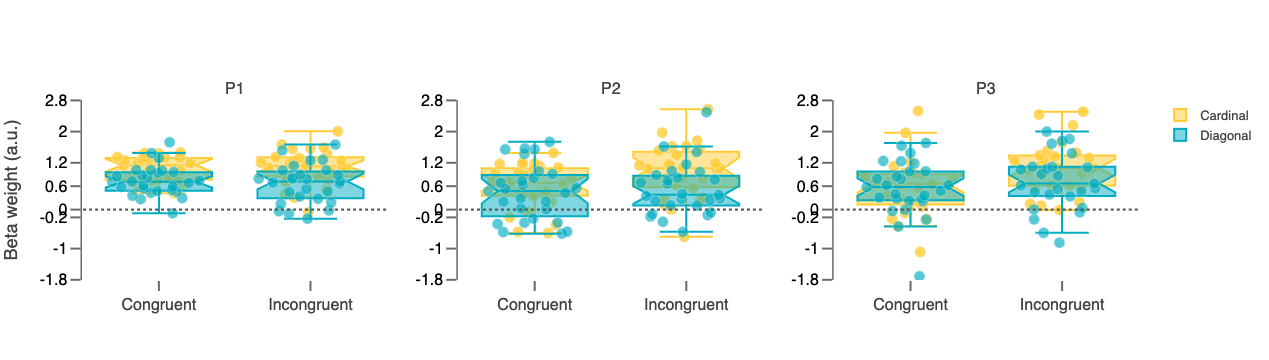

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal',
    marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], 
                 ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [ ]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0              nrep  2.249762      2     52  1.124881  4.725408  0.013013   
1         cong_deci  3.756905      1     26  3.756905  8.257388  0.007982   
2  nrep * cong_deci  1.637936      2     52  0.818968  2.925429  0.062522   

   p-GG-corr       np2       eps  
0   0.017580  0.153795  0.862711  
1   0.007982  0.241040  1.000000  
2   0.066848  0.101137  0.929404

In [ ]:
dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2),:]
pg.pairwise_ttests(dv='weight', within= ['cond', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast cond  A  B Paired  Parametric         T   dof       Tail  \
0              cond    -  C  D   True        True  1.041703  26.0  two-sided   
1         cong_deci    -  C  I   True        True -2.255165  26.0  two-sided   
2  cond * cong_deci    C  C  I   True        True -2.574830  26.0  two-sided   
3  cond * cong_deci    D  C  I   True        True -1.132627  26.0  two-sided   

      p-unc    p-corr p-adjust   BF10     cohen  
0  0.307139       NaN      NaN  0.333  0.262851  
1  0.032768       NaN      NaN  1.746 -0.649987  
2  0.016072  0.032143     bonf  3.134 -0.712635  
3  0.267708  0.535417     bonf  0.363 -0.333281

In [ ]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0       nrep  0  1    True        True  1.954473  26.0  two-sided  0.061479   
1       nrep  0  2    True        True -0.003172  26.0  two-sided  0.997493   
2       nrep  1  2    True        True -1.738290  26.0  two-sided  0.093991   
3  cong_deci  C  I    True        True -0.926794  26.0  two-sided  0.362557   

     p-corr p-adjust   BF10     cohen  
0  0.184437     bonf  1.058  0.499663  
1  1.000000     bonf  0.204 -0.000868  
2  0.281973     bonf  0.763 -0.377056  
3       NaN      NaN  0.301 -0.234961

<font size="5"> _Figure 6B. Intercept for Categorical similarity between stimuli samples and previous decisions._

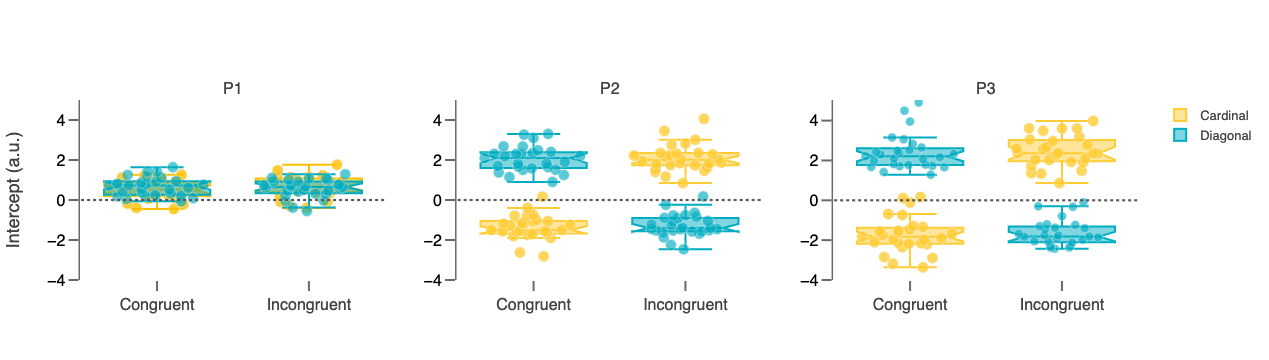

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=True, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal',marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=9,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))
fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Intercept (a.u.)", 
                  font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", 
                              font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-4, 5]); fig['layout']['yaxis2'].update(range=[-4, 5])
fig['layout']['yaxis3'].update(range=[-4, 5.034])

fig.show()

<font size="4"> Statistical tests for Intercept

In [ ]:
# Cardinal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source          SS  ddof1  ddof2          MS           F  \
0              nrep    1.636823      2     52    0.818411    4.140423   
1         cong_deci  275.743248      1     26  275.743248  258.756344   
2  nrep * cong_deci  124.524859      2     52   62.262430  168.648626   

          p-unc     p-GG-corr       np2       eps  
0  2.144984e-02  2.596399e-02  0.137371  0.892744  
1  4.966187e-15  4.966187e-15  0.908694  1.000000  
2  1.856830e-23  1.277561e-16  0.866426  0.676656

In [ ]:
# Diagonal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

Source          SS  ddof1  ddof2          MS           F  \
0              nrep    3.436114      2     52    1.718057    7.362840   
1         cong_deci  265.394084      1     26  265.394084  205.854769   
2  nrep * cong_deci  128.269370      2     52   64.134685   96.189332   

          p-unc     p-GG-corr       np2       eps  
0  1.529215e-03  2.454520e-03  0.220690  0.882641  
1  7.261261e-14  7.261261e-14  0.887861  1.000000  
2  3.360791e-18  5.051936e-13  0.787215  0.674975

In [ ]:
dat1 = dat.loc[dat.nrep==2]
np.mean(dat1.intercept)

0.27519521493992277

In [ ]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_deci'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric          T   dof       Tail  \
0       nrep  0  1    True        True   2.396753  26.0  two-sided   
1       nrep  0  2    True        True   3.051665  26.0  two-sided   
2       nrep  1  2    True        True   0.004395  26.0  two-sided   
3  cong_deci  C  I    True        True -16.085905  26.0  two-sided   

          p-unc    p-corr p-adjust       BF10     cohen  
0  2.402315e-02  0.072069     bonf      2.249  0.557865  
1  5.189772e-03  0.015569     bonf      8.143  0.501211  
2  9.965272e-01  1.000000     bonf      0.204  0.001052  
3  4.966187e-15       NaN      NaN  1.215e+12 -4.983536

<font size="5"> _Figure 7. β Weight by Incongruent Samples minus β Weight by Congruent Samples divided by Ambiguous and Unambiguous samples and by Conditions._

- Ambiguous (DV = -0.3 to 0.3)
- Unambiguous (DV = 1 to -0.3 and 0.3 to 1)

<font size="3"> _Logisitc regression model to plot Figure 7_

In [ ]:
new_dflong = dflong
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #this participants has not data for small bins

n_par = np.unique(new_dflong.npar)   #pre_deci
n_bins= np.array([-0.60, 0, 0.60])
log_reg_cong_bins = pd.DataFrame([]) # concatenate participants

formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins = pd.concat([log_reg_cong_bins, log_reg], axis = 0)
    
log_reg_cong_bins.reset_index(inplace = True)
log_reg_cong_bins.head(10)

npar  nrep cond cong_deci bins  level_5  intercept    weight       PSE
0   1.0     0    C         C -0.6        0   0.202001  0.478565 -0.422097
1   1.0     0    C         I -0.6        0   0.585941  0.970050 -0.604031
2   1.0     1    C         C -0.6        0  -0.831635  1.202241  0.691737
3   1.0     1    C         I -0.6        0   1.853114  1.028917 -1.801034
4   1.0     2    C         C -0.6        0  -1.451881  0.402832  3.604187
5   1.0     2    C         I -0.6        0   1.947116  0.957039 -2.034521
6   1.0     0    C         C  0.0        0   0.232816  1.057217 -0.220216
7   1.0     0    C         I  0.0        0   0.901060  0.924804 -0.974325
8   1.0     0    D         C  0.0        0   0.296233  1.780832 -0.166345
9   1.0     0    D         I  0.0        0   0.991398 -1.183951  0.837364

In [ ]:
# first step: coding the new necessary variables  
# to substract β Weight in Congruent Samples to β Weight in Incongruent Samples

log_reg_cong_bins.insert(7,'intercept-1', 0)
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept']
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(9,'weight-1', 0)
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight']
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(8, 'bias', 0)
log_reg_cong_bins['bias'] = log_reg_cong_bins['intercept'] - log_reg_cong_bins['intercept-1']

log_reg_cong_bins.insert(10, 'slope', 0)
log_reg_cong_bins['slope'] = log_reg_cong_bins['weight'] - log_reg_cong_bins['weight-1']
log_reg_cong_bins.head()

npar  nrep cond cong_deci bins  level_5  intercept  intercept-1      bias  \
0   1.0     0    C         C -0.6        0   0.202001     0.000000  0.202001   
1   1.0     0    C         I -0.6        0   0.585941     0.202001  0.383939   
2   1.0     1    C         C -0.6        0  -0.831635     0.585941 -1.417575   
3   1.0     1    C         I -0.6        0   1.853114    -0.831635  2.684748   
4   1.0     2    C         C -0.6        0  -1.451881     1.853114 -3.304995   

     weight     slope  weight-1       PSE  
0  0.478565  0.478565  0.000000 -0.422097  
1  0.970050  0.491485  0.478565 -0.604031  
2  1.202241  0.232191  0.970050  0.691737  
3  1.028917 -0.173324  1.202241 -1.801034  
4  0.402832 -0.626085  1.028917  3.604187

In [ ]:
# second step: drop unnecessary columns 
log_reg_cong_bins = log_reg_cong_bins.loc[(log_reg_cong_bins.cong_deci == 'I'),:]
log_reg_cong_bins = log_reg_cong_bins.drop(columns=['intercept-1', 'intercept', 'cong_deci', 
                                                    'weight', 'weight-1', 'PSE', 'level_5'])
log_reg_cong_bins.head()

npar  nrep cond bins      bias     slope
1   1.0     0    C -0.6  0.383939  0.491485
3   1.0     1    C -0.6  2.684748 -0.173324
5   1.0     2    C -0.6  3.398996  0.554207
7   1.0     0    C  0.0  0.668244 -0.132413
9   1.0     0    D  0.0  0.695165 -2.964783

In [ ]:
# third step: convert the variable "bins" in a categorical variable
log_reg_cong_bins["bins"] = log_reg_cong_bins["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_cong_bins.head()

npar  nrep cond        bins      bias     slope
1   1.0     0    C  not_ambigu  0.383939  0.491485
3   1.0     1    C  not_ambigu  2.684748 -0.173324
5   1.0     2    C  not_ambigu  3.398996  0.554207
7   1.0     0    C      ambigu  0.668244 -0.132413
9   1.0     0    D      ambigu  0.695165 -2.964783

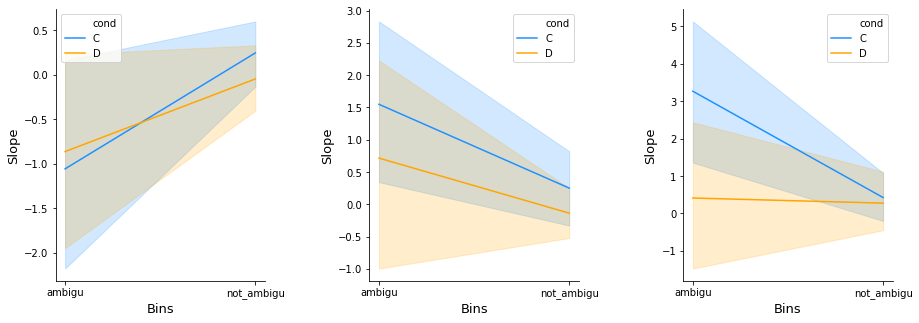

In [ ]:
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

sns.despine(top=True)

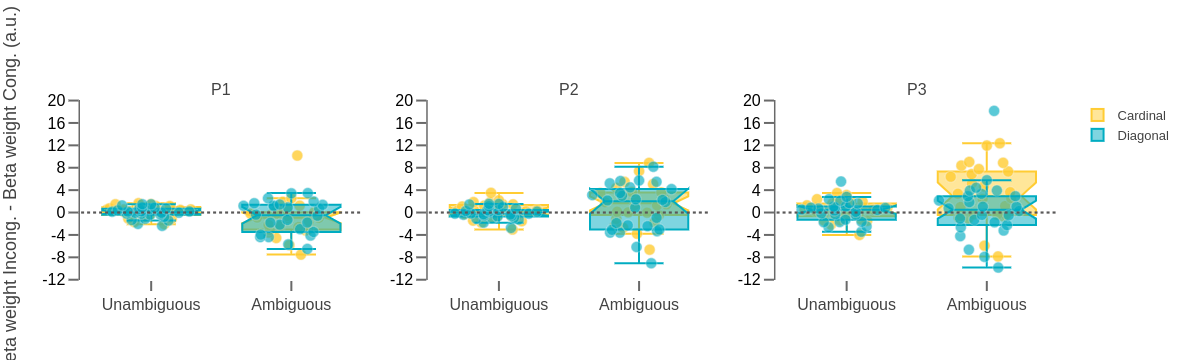

In [ ]:
# final step: plot the data
from plotly.subplots import make_subplots
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], opacity = 0.8, x=dat['bins'], boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], boxpoints='all', showlegend=False, opacity = 1,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=3) 

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Unambiguous', 'Ambiguous'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], 
                 ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Beta weight Incong. - Beta weight Cong. (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif", size=13, color="#424242")))

fig['layout']['yaxis1'].update(range=[-12.05, 20.1]); fig['layout']['yaxis2'].update(range=[-12.05, 20.1])
fig['layout']['yaxis3'].update(range=[-12.05, 20.1])

fig.show()

<font size="4"> _Statistical tests_

Test whether differences in weight between congruent and incongruent samples with previous decisions depend by the ambiguity of the stimuli sample. 

<font size="2"> _t-test for unambiguous_

In [ ]:
# t test for Cardinal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  1.2429   25  two-sided  0.2254  [-0.16, 0.64]   0.2438  0.413  0.2231

In [ ]:
# t test for Cardinal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  0.8903   25  two-sided  0.3818  [-0.33, 0.83]   0.1746  0.297  0.1373

In [ ]:
# t test for Cardinal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test  1.2598   25  two-sided  0.2194  [-0.27, 1.12]   0.2471  0.421  0.2279

In [ ]:
# t test for Diagonal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -0.2522   25  two-sided  0.8029  [-0.45, 0.35]   0.0495  0.213  0.0568

In [ ]:
# t test for Diagonal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -0.6725   25  two-sided  0.5074  [-0.55, 0.28]   0.1319  0.255  0.0992

In [ ]:
# t test for Diagonal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d   BF10   power
T-test  0.731   25  two-sided  0.4716  [-0.5, 1.05]   0.1434  0.264  0.1083

<font size="2"> _t-test for ambiguous_

In [ ]:
# t test for Cardinal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val          CI95%  cohen-d   BF10   power
T-test -1.6617   25  two-sided  0.1091  [-2.37, 0.25]   0.3259  0.693  0.3589

In [ ]:
# t test for Cardinal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d   BF10   power
T-test  2.2758   25  two-sided  0.0317  [0.15, 2.95]   0.4463  1.819  0.5902

In [ ]:
# t test for Cardinal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep == 2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail  p-val         CI95%  cohen-d    BF10   power
T-test  3.2932   25  two-sided  0.003  [1.22, 5.31]   0.6459  13.372  0.8858

In [ ]:
# t test for Diagonal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail   p-val         CI95%  cohen-d   BF10   power
T-test -1.5317   25  two-sided  0.1381  [-2.02, 0.3]   0.3004  0.582  0.3135

In [ ]:
# t test for Diagonal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail  p-val          CI95%  cohen-d   BF10   power
T-test  0.8562   25  two-sided    0.4  [-1.01, 2.44]   0.1679  0.289  0.1306

In [ ]:
# t test for Diagonal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

T  dof       tail  p-val          CI95%  cohen-d   BF10  power
T-test  0.398   25  two-sided  0.694  [-1.72, 2.55]   0.0781  0.223  0.067

Post-hoc t-test: one chunck for each presentation

In [ ]:
# post-hoc t-test for P1
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==0]) 

Contrast        bins           A       B Paired  Parametric         T  \
0         bins           -  not_ambigu  ambigu   True        True  3.662612   
1         cond           -           C       D   True        True  0.095074   
2  bins * cond  not_ambigu           C       D   True        True  1.123136   
3  bins * cond      ambigu           C       D   True        True -0.189045   

    dof       Tail     p-unc    p-corr p-adjust    BF10     cohen  
0  25.0  two-sided  0.001172       NaN      NaN  29.917  0.847750  
1  25.0  two-sided  0.925014       NaN      NaN   0.208  0.029604  
2  25.0  two-sided  0.272050  0.544101     bonf   0.365  0.293154  
3  25.0  two-sided  0.851584  1.000000     bonf   0.211 -0.063258

In [ ]:
# post-hoc t-test for P2
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==1]) 

Contrast        bins           A       B Paired  Parametric         T  \
0         bins           -  not_ambigu  ambigu   True        True -2.093122   
1         cond           -           C       D   True        True  1.025191   
2  bins * cond  not_ambigu           C       D   True        True  1.068622   
3  bins * cond      ambigu           C       D   True        True  0.741926   

    dof       Tail     p-unc    p-corr p-adjust   BF10     cohen  
0  25.0  two-sided  0.046646       NaN      NaN  1.334 -0.550357  
1  25.0  two-sided  0.315091       NaN      NaN  0.333  0.290866  
2  25.0  two-sided  0.295450  0.590901     bonf  0.347  0.309386  
3  25.0  two-sided  0.465046  0.930092     bonf  0.266  0.214317

In [ ]:
# post-hoc t-test for P3
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==2]) 

Contrast        bins           A       B Paired  Parametric         T  \
0         bins           -  not_ambigu  ambigu   True        True -2.245352   
1         cond           -           C       D   True        True  1.556510   
2  bins * cond  not_ambigu           C       D   True        True  0.333949   
3  bins * cond      ambigu           C       D   True        True  1.686901   

    dof       Tail     p-unc    p-corr p-adjust   BF10     cohen  
0  25.0  two-sided  0.033832       NaN      NaN  1.725 -0.659875  
1  25.0  two-sided  0.132157       NaN      NaN  0.602  0.521835  
2  25.0  two-sided  0.741203  1.000000     bonf  0.218  0.081805  
3  25.0  two-sided  0.104063  0.208126     bonf  0.718  0.551901

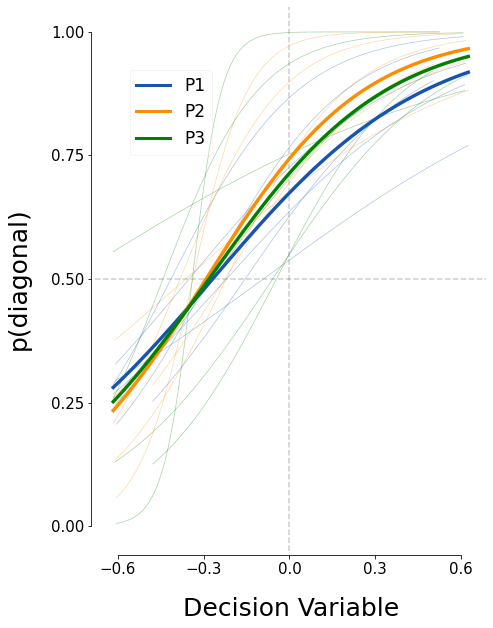

In [37]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
subj_labels = np.unique(df.subj) #subj

#mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
for i in subj_labels: #for loop to compute the average by each participant
    df2=df.loc[df.subj == i,:]
    for cell in nrep_labels:
     #   sns.set_palette(mycol)
        ax = sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                         line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject

for cell in nrep_labels: #for loop to compute the plot by the average sample
   # sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=df.loc[df.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                     line_kws ={'lw':3.4});
    
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
#plt.savefig('deci_x_nrep.png',bbox_inches='tight')

In [43]:
# make the model to estimate if there are statistical differences in weight or the intercept
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['subj', 'nrep']).apply(log_reg_fit, formula)
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.tail(5)

subj  nrep  level_2  intercept    weight       PSE
16  s01c     1        0   1.243339  4.948249 -0.251269
17  s01c     2        0   0.222493  4.415689 -0.050387
18  s03c     0        0   2.824360  6.668908 -0.423512
19  s03c     1        0   2.641980  6.988926 -0.378024
20  s03c     2        0   2.643170  5.975526 -0.442333

In [44]:
# Means in weight for presentation

dat = log_reg_nrep.loc[log_reg_nrep.nrep == 0,:] # without pre_deci as a factor
print('Weight mean at P1: ')
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 1,:] # without pre_deci as a factor
print('Weight mean at P2: ')
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 2,:] # without pre_deci as a factor
print('Weight mean at P31: ')
print(np.mean(dat.weight))

Weight mean at P1: 
3.2069246836799032
Weight mean at P2: 
5.216490302035413
Weight mean at P31: 
5.509572395158751


In [46]:
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep'], subject = 'subj', data=log_reg_nrep, detailed = True, correction = True)

Source          SS  DF         MS         F     p-unc  p-GG-corr       np2  \
0   nrep   21.995021   2  10.997510  1.232876  0.325868    0.31134  0.170455   
1  Error  107.042464  12   8.920205       NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.528925      False  0.109374  0.003956  
1       NaN        NaN       NaN       NaN

In [19]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within='nrep', subject='npar', padjust='bonf', 
                   tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.671619  26.0  two-sided  0.106594   
1     nrep  0  2    True        True -4.630703  26.0  two-sided  0.000089   
2     nrep  1  2    True        True -3.775923  26.0  two-sided  0.000836   

     p-corr p-adjust     BF10     cohen  
0  0.319782     bonf    0.694 -0.182036  
1  0.000267     bonf  294.011 -0.465816  
2  0.002509     bonf   39.864 -0.272053